In [10]:
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [11]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [12]:
def load_audio_features(file_path, fixed_length=130):
    """
    加载音频并提取特征
    """
    try:
        # 加载音频文件
        y, sr = librosa.load(file_path)
        
        # 提取Mel频谱图
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # 提取MFCC特征
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        
        # 统一长度处理
        def pad_or_truncate(array, target_length):
            current_length = array.shape[1]
            if current_length > target_length:
                return array[:, :target_length]
            else:
                pad_width = ((0, 0), (0, target_length - current_length))
                return np.pad(array, pad_width, mode='constant')
        
        # 处理特征长度
        mel_spec_db = pad_or_truncate(mel_spec_db, fixed_length)
        mfccs = pad_or_truncate(mfccs, fixed_length)
        
        return {
            'mel_spec': mel_spec_db.astype(np.float32),
            'mfcc': mfccs.astype(np.float32)
        }
    
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [14]:
class AudioTransformer(nn.Module):
    def __init__(self, mel_channels=128, mfcc_channels=20, d_model=256, nhead=8, 
                 num_layers=4, dim_feedforward=1024, dropout=0.1):
        super().__init__()
        
        # Feature embedding layers
        self.mel_embed = nn.Linear(mel_channels, d_model)
        self.mfcc_embed = nn.Linear(mfcc_channels, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, mel_spec, mfcc):
        # Process Mel spectrogram
        mel_embedded = self.mel_embed(mel_spec.squeeze(1).transpose(1, 2))
        mel_encoded = self.pos_encoder(mel_embedded)
        
        # Process MFCC
        mfcc_embedded = self.mfcc_embed(mfcc.transpose(1, 2))
        mfcc_encoded = self.pos_encoder(mfcc_embedded)
        
        # Combine features
        combined = torch.cat([mel_encoded, mfcc_encoded], dim=1)
        
        # Apply Transformer encoder
        transformer_output = self.transformer_encoder(combined)
        
        # Global average pooling
        pooled = torch.mean(transformer_output, dim=1)
        
        # Classification
        output = self.classifier(pooled)
        
        return output

In [15]:
class DeceptionDataset(torch.utils.data.Dataset):
    def __init__(self, features_list, labels):
        self.features = features_list
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        mel_spec = torch.FloatTensor(self.features[idx]['mel_spec']).unsqueeze(0)
        mfcc = torch.FloatTensor(self.features[idx]['mfcc'])
        label = torch.FloatTensor([self.labels[idx]])
        
        return {
            'mel_spec': mel_spec,
            'mfcc': mfcc,
            'label': label
        }

In [16]:
def train_model(model, train_loader, val_loader, epochs=100, patience=10):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # 降低学习率
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch in train_loader:
            mel_spec = batch['mel_spec'].to(device)
            mfcc = batch['mfcc'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            outputs = model(mel_spec, mfcc)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                mel_spec = batch['mel_spec'].to(device)
                mfcc = batch['mfcc'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(mel_spec, mfcc)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                preds = (outputs > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_labels, all_preds)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stopping_counter += 1
        
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, '
              f'Val Accuracy: {val_accuracy:.4f}')
    
    return history

In [17]:
def main():
    # 配置参数
    csv_path = 'CBU0521DD_stories_attributes.csv'
    audio_dir = 'Deception/Deception-main/CBU0521DD_stories'
    batch_size = 8  # 减小批量大小以适应Transformer
    fixed_length = 130
    
    # 加载数据
    df = pd.read_csv(csv_path)
    features_list = []
    labels = []
    
    print("Loading and processing audio files...")
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        audio_path = f"{audio_dir}/{row['filename']}"
        features = load_audio_features(audio_path, fixed_length=fixed_length)
        
        if features is not None:
            features_list.append(features)
            labels.append(1 if 'True Story' in row['Story_type'] else 0)
    
    # 划分数据集
    X_train, X_val, y_train, y_val = train_test_split(
        features_list, labels, test_size=0.2, random_state=42
    )
    
    # 创建数据加载器
    train_dataset = DeceptionDataset(X_train, y_train)
    val_dataset = DeceptionDataset(X_val, y_val)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size
    )
    
    # 初始化并训练模型
    model = AudioTransformer()
    print("Starting training...")
    history = train_model(model, train_loader, val_loader)
    
    # 绘制训练历史
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Loading and processing audio files...


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Starting training...


d:\conda\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/100], Loss: 0.7157, Val Loss: 0.6982, Val Accuracy: 0.4500
Epoch [2/100], Loss: 0.7147, Val Loss: 0.7055, Val Accuracy: 0.4500
Epoch [3/100], Loss: 0.6910, Val Loss: 0.6977, Val Accuracy: 0.4500
Epoch [4/100], Loss: 0.6981, Val Loss: 0.6961, Val Accuracy: 0.4500
Epoch [5/100], Loss: 0.6957, Val Loss: 0.7075, Val Accuracy: 0.4500
Epoch [6/100], Loss: 0.6918, Val Loss: 0.6988, Val Accuracy: 0.4500
Epoch [7/100], Loss: 0.6967, Val Loss: 0.6897, Val Accuracy: 0.5500
Epoch [8/100], Loss: 0.6974, Val Loss: 0.6947, Val Accuracy: 0.3000
Epoch [9/100], Loss: 0.6869, Val Loss: 0.6987, Val Accuracy: 0.4500
Epoch [10/100], Loss: 0.7115, Val Loss: 0.6882, Val Accuracy: 0.5500
Epoch [11/100], Loss: 0.6879, Val Loss: 0.7075, Val Accuracy: 0.4500
Epoch [12/100], Loss: 0.6850, Val Loss: 0.6995, Val Accuracy: 0.3000
Epoch [13/100], Loss: 0.6755, Val Loss: 0.7552, Val Accuracy: 0.4500
Epoch [14/100], Loss: 0.6539, Val Loss: 0.6716, Val Accuracy: 0.6500
Epoch [15/100], Loss: 0.6399, Val Loss: 0.8

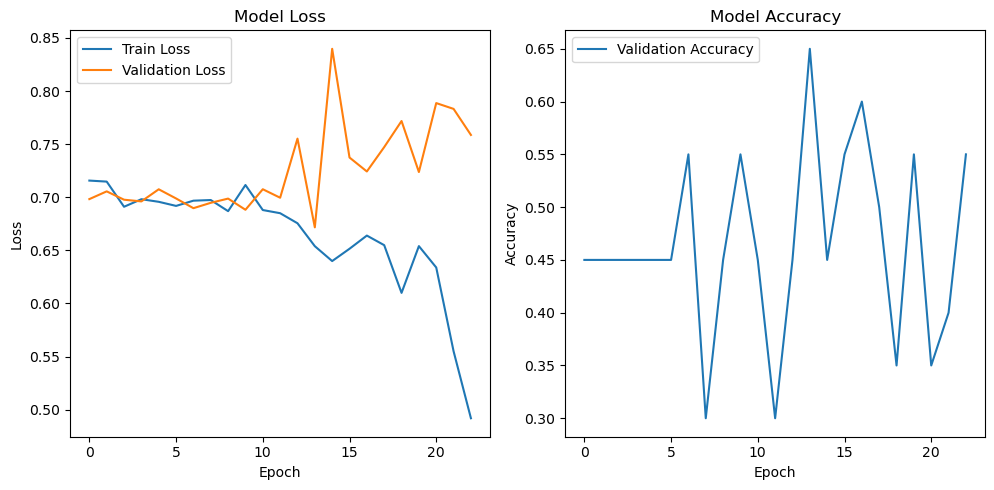

In [18]:
if __name__ == "__main__":
    main()